When optuna is used as an optimization criterion for the percentage of correct answers in the test data

| model        | overview | F1 score  | accuracy | recall | specificity |
|--------------|----------|---------------|----------------| ------------ | ------------|
| CNN ( layer 5 )         | size : 256x256,  epochs : 10, batch_size : 256 | 0.895 | 0.866 | 0.907 | 0.799 |
| CNN ( layer 7 )  | size : 256x256 , epochs : 10, batch_size : 64 | 0.935 | 0.916 | 0.958 | 0.846 |
| Resnet34     | size : 256x256, epochs : 10, batch_size : 256 | 0.951 | 0.940 | 0.935 | 0.948 |
| EfficientnetV2_b0 | size : 256x256, epochs : 10, batch_size : 64 | 0.931 | 0.918 | 0.889 | 0.965 |
| VGG16        | size : 256x256, epochs : 10, batch_size : 128 | none | 0.871 | none | none |


## Import library 

In [1]:
import random
import os
import gc

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report,f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import Adam
from torchsummary import summary
import torch.backends.cudnn as cudnn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from PIL import Image

import timm
from collections import Counter

c:\Users\morik\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


## <span style="color: red">torch_seed must be run as needed to ensure reproducibility</span>

In [2]:
class CFG:
    def __init__(self):

        self.seed=777
        self.epochs=10
        self.batch_size=[64,128,256,512]
        self.learning_rate=0.00001
        self.input_class=None
        self.output_class=2
        self.img_size=256

        self.device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

        self.class_mapping = {
            "NORMAL":0,
            'PNEUMONIA':1,
        }
        

config=CFG()

# fix seed
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def torch_seed(seed=config.seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms=True
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    g = torch.Generator()
    g.manual_seed(seed)

torch_seed()

## Load data

## Train

In [3]:
def Load(dir):
    filepaths=[]
    labels=[]

    folds=os.listdir(dir)

    for fold in folds:
        foldpath=os.path.join(dir,fold)
        filelist=os.listdir(foldpath)
        for file in filelist:
            path=os.path.join(foldpath,file)
            filepaths.append(path)
            labels.append(fold)

    X=pd.Series(filepaths,name="filepaths")
    y=pd.Series(labels,name="labels")
    df=pd.concat([X,y],axis=1)

    return df

train_dir=".//train"
test_dir=".//test"
val_dir=".//val"

train_df=Load(train_dir)
test_df=Load(test_dir)
val_df=Load(val_dir)


In [4]:
train_df.head()

,filepaths,labels
0,.//train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,.//train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,.//train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,.//train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,.//train\NORMAL\IM-0125-0001.jpeg,NORMAL


In [5]:
test_df.head()

,filepaths,labels
0,.//test\NORMAL\IM-0001-0001.jpeg,NORMAL
1,.//test\NORMAL\IM-0003-0001.jpeg,NORMAL
2,.//test\NORMAL\IM-0005-0001.jpeg,NORMAL
3,.//test\NORMAL\IM-0006-0001.jpeg,NORMAL
4,.//test\NORMAL\IM-0007-0001.jpeg,NORMAL


In [6]:
val_df.head()

,filepaths,labels
0,.//val\NORMAL\NORMAL2-IM-1427-0001.jpeg,NORMAL
1,.//val\NORMAL\NORMAL2-IM-1430-0001.jpeg,NORMAL
2,.//val\NORMAL\NORMAL2-IM-1431-0001.jpeg,NORMAL
3,.//val\NORMAL\NORMAL2-IM-1436-0001.jpeg,NORMAL
4,.//val\NORMAL\NORMAL2-IM-1437-0001.jpeg,NORMAL


# Show data

labels
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


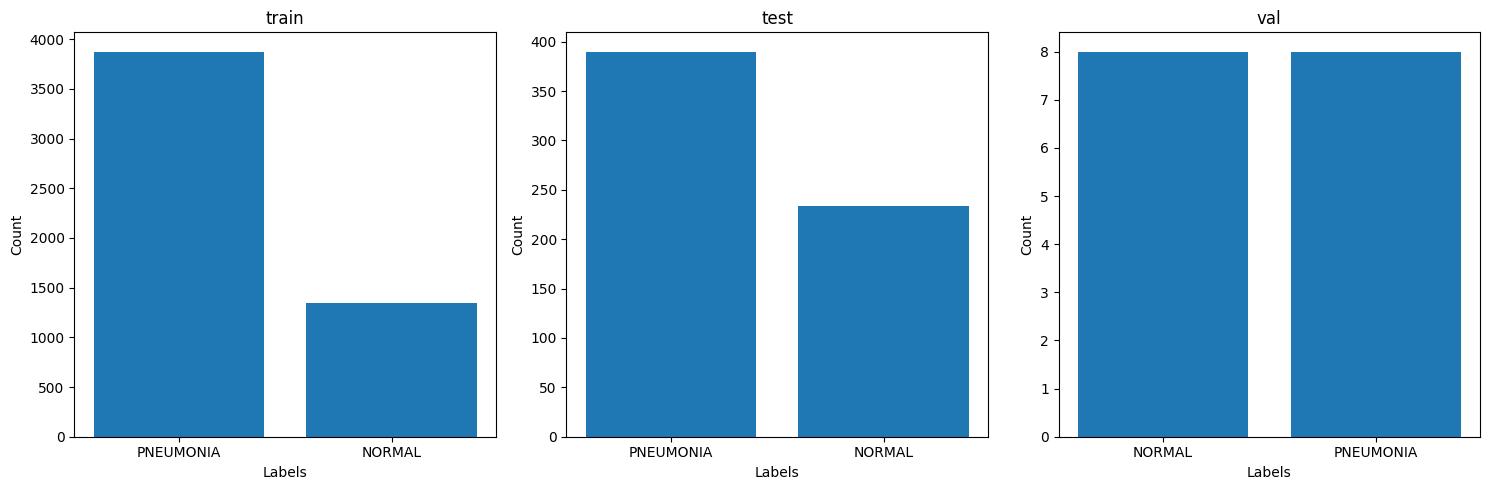

In [7]:
def Show(train_df,test_df,val_df):
    fig,axs=plt.subplots(1,3,figsize=(15,5))

    for i,(name,df) in enumerate(zip(["train","test","val"],[train_df,test_df,val_df])):
        label_counts=df["labels"].value_counts()
        axs[i].bar(label_counts.index,label_counts.values)
        axs[i].set_title(name)
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Count')
        axs[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

print(train_df["labels"].value_counts())
Show(train_df,test_df,val_df)

# Processing

In [8]:
# Normal -> 0 , Pneumonia -> 1
def encode(df):
    df["labels"]=df["labels"].map(config.class_mapping)

encode(train_df)
encode(test_df)
encode(val_df)

The number of channels is set to 3 because the pretrained model sets the input channels to 3.


In [9]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
img_size=config.img_size


transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),  
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums,std=std_nums)
                                ])

test_transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums,std=std_nums)
                                ])

# Transform Image

In [10]:
class ImageDataset(Dataset):

    def __init__(self,filepaths,labels,transform=None):
        self.filepaths=filepaths
        self.labels=labels
        self.transform=transform
    
    def __getitem__(self,index):
        torch_seed()
        img=Image.open(self.filepaths[index])
        if self.transform is not None:
            img=self.transform(img)
        label=self.labels[index]
        return img,label
    
    def __len__(self):
        return len(self.labels)


train_dataset=ImageDataset(train_df["filepaths"],train_df["labels"],transform)
valid_dataset=ImageDataset(val_df["filepaths"],val_df["labels"],transform)
test_dataset=ImageDataset(test_df["filepaths"],test_df["labels"],test_transform)

train,valid=train_test_split(train_dataset,test_size=0.2,random_state=config.seed)

valid_dataloader is created from train and valid_2_dataloader is created from val

In [11]:
# batch_size = [64,128,256]
train_dataloader_64=DataLoader(train,batch_size=config.batch_size[0],worker_init_fn=worker_init_fn,shuffle=True)
valid_dataloader_64=DataLoader(valid,batch_size=config.batch_size[0],worker_init_fn=worker_init_fn,shuffle=True)

train_dataloader_128=DataLoader(train,batch_size=config.batch_size[1],worker_init_fn=worker_init_fn,shuffle=True)
valid_dataloader_128=DataLoader(valid,batch_size=config.batch_size[1],worker_init_fn=worker_init_fn,shuffle=True)

train_dataloader_256=DataLoader(train,batch_size=config.batch_size[2],worker_init_fn=worker_init_fn,shuffle=True)
valid_dataloader_256=DataLoader(valid,batch_size=config.batch_size[2],worker_init_fn=worker_init_fn,shuffle=True)

train_dataloader={"64":train_dataloader_64,
                  "128":train_dataloader_128,
                  "256":train_dataloader_256
                  }

valid_dataloader={"64":valid_dataloader_64,
                  "128":valid_dataloader_128,
                  "256":valid_dataloader_256
                  }

valid_2_dataloader=DataLoader(valid_dataset,shuffle=False)
test_dataloader=DataLoader(test_dataset,shuffle=False)

In [12]:
print(len(train))
print(len(valid))
print(len(valid_dataset))
print(len(test_dataset))

4172
1044
16
624


In [13]:
## save hyper parameters found by optuna
def save_params(name,params):
    file_name = f"{name}.txt"

    with open(file_name, 'w') as file:
        for key, value in params.items():
            file.write(f"{key}: {value}\n")

## save model
def save_model(name,model):
    model_scripted = torch.jit.script(model)
    file_name=f"{name}.pth"
    model_scripted.save(file_name)

# clear cuda memory
def clear():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.memory_allocated()

# plot train and eval result
def plot_result(loss_list,val_loss_list,val_acc_list,cm):
    plt.plot(loss_list,label="train_loss")
    plt.plot(val_loss_list,label="val_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.figure()
    plt.plot(val_acc_list,label="val_acc")
    plt.legend()
    plt.ylim(0.7,1)
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
device=config.device

def train(model,optimizer,train_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0

    model.train()
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        pred=model(X)
        loss=criterion(pred,y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()
        # count=Counter(y.cpu().numpy())
        # print(count)

    train_loss=loss_sum/len(train_dataloader)

    return train_loss

def valid(model,valid_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0
    correct=0
    total=0

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in valid_dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            loss=criterion(pred,y)
            loss_sum+=loss.item()
            pred=pred.max(1, keepdim=True)[1]
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
            #count=Counter(y.cpu().numpy())
            #print(count)
    
    val_loss=loss_sum/len(valid_dataloader)
    val_acc=correct/total
    return val_loss,val_acc

def test(model,test_data):
    correct=0
    total=0
    y_true=[]
    y_pred=[]

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in test_data:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            pred=pred.max(1, keepdim=True)[1]
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    test_acc=correct/total
    return test_acc,cm,y_pred

# CNN ( 5 layers )

In [14]:
class Model(nn.Module):

    def __init__(self,fc1_out):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.dropout1=nn.Dropout(0.1)
        self.dropout2=nn.Dropout(0.2)
        
        self.conv1=nn.Conv2d(3,16,kernel_size=3)
        self.conv2=nn.Conv2d(16,32,kernel_size=3)
        self.conv3=nn.Conv2d(32,64,kernel_size=3)

        self.fc1=nn.Linear(64*30*30,fc1_out)
        self.fc2=nn.Linear(fc1_out,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.dropout1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.dropout2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        return x

# show exsample of model
CNN=Model(2048).to(config.device)
summary(CNN,(3,256,256))    # summary(model,(channel,size,size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
           Dropout-5         [-1, 32, 125, 125]               0
              ReLU-6         [-1, 32, 125, 125]               0
         MaxPool2d-7           [-1, 32, 62, 62]               0
            Conv2d-8           [-1, 64, 60, 60]          18,496
           Dropout-9           [-1, 64, 60, 60]               0
             ReLU-10           [-1, 64, 60, 60]               0
        MaxPool2d-11           [-1, 64, 30, 30]               0
           Linear-12                 [-1, 2048]     117,966,848
             ReLU-13                 [-1, 2048]               0
           Linear-14                   

## Find best hyper parameters by optuna

In [ ]:
# def objective(trial):
#     clear()
#     torch_seed()

#     epochs=10
#     fc1_out=trial.suggest_int('fc1_out',64,2048)
#     learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)
#     batch_size=trial.suggest_categorical("batch_size",["64","128","256"])

#     model=Model(fc1_out).to(device=config.device)
#     optimizer=Adam(model.parameters(),lr=learning_rate)
    
#     torch_seed()
#     for epoch in range(epochs):
#         loss=train(model,optimizer,train_dataloader[batch_size])
#         val_loss,val_acc=valid(model,valid_dataloader[batch_size])
#         print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
#     test_acc,_,__=test(model,test_dataloader)

#     return test_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# cnn_params = study.best_params
# print("Best Hyperparameters:", cnn_params)

# best_trial=study.best_trial
# save_params(f"cnn_best_{best_trial.value}",cnn_params)

## Best model of CNN ( 5 layers )

### best hyper parameters
- fc1_out = 1641
- learning_rate = 0.0008870770921362339
- batch_size = "256"

fc1 out : 1641  learning rate : 0.0008870770921362339  batch size : 256
train loss : 2.2726041429183064  val_loss : 0.3936220645904541  val_acc : 0.9090038314176245 
train loss : 0.2174086785491775  val_loss : 0.1274480015039444  val_acc : 0.9549808429118773 
train loss : 0.11402955738937154  val_loss : 0.09818094521760941  val_acc : 0.9693486590038314 
train loss : 0.0965814025086515  val_loss : 0.07486021891236305  val_acc : 0.975095785440613 
train loss : 0.07479411823784604  val_loss : 0.09922298938035964  val_acc : 0.9712643678160919 
train loss : 0.07734209430568359  val_loss : 0.05884113758802414  val_acc : 0.9779693486590039 
train loss : 0.06138161065823892  val_loss : 0.06985162124037743  val_acc : 0.9722222222222222 
train loss : 0.048594046274528784  val_loss : 0.061341692507266996  val_acc : 0.9779693486590039 
train loss : 0.04094333333127639  val_loss : 0.05282168723642826  val_acc : 0.9808429118773946 
train loss : 0.03268477101536358  val_loss : 0.052349993586540224  v

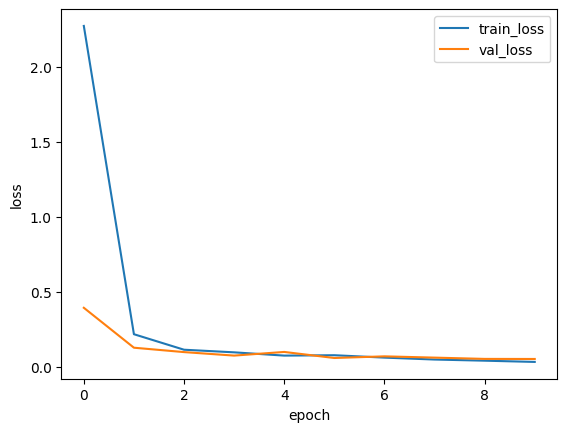

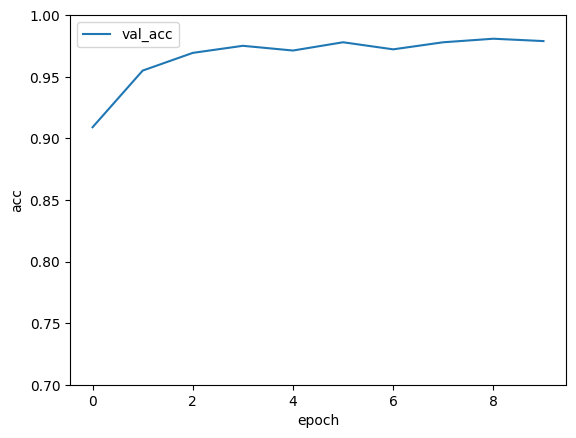

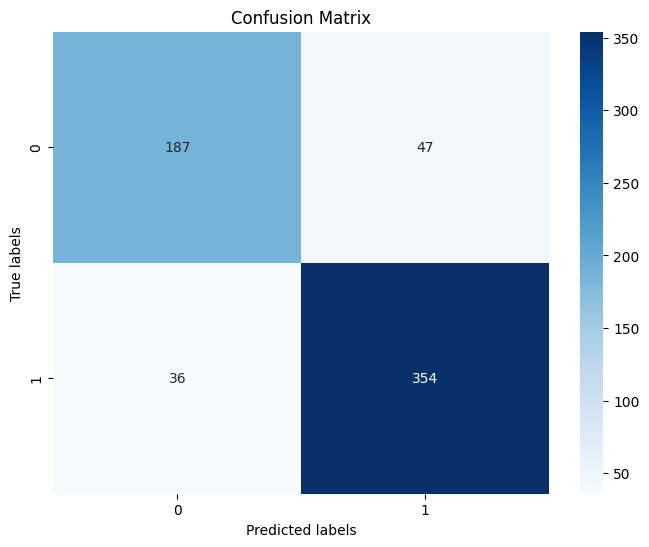

In [58]:
clear()
torch_seed()

loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=10

fc1_out=1641
learning_rate=0.0008870770921362339
batch_size="256"

print(f"fc1 out : {fc1_out}  learning rate : {learning_rate}  batch size : {batch_size}")

cnn_best=Model(fc1_out).to(device=config.device)
optimizer=Adam(cnn_best.parameters(),lr=learning_rate)

torch_seed()
for epoch in range(epochs):
    loss=train(cnn_best,optimizer,train_dataloader[batch_size])
    val_loss,val_acc=valid(cnn_best,valid_dataloader[batch_size])
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


test_acc,cm,pred=test(cnn_best,test_dataloader)
print(f"test accuracy : {test_acc}")
f_score=f1_score(pred,test_df["labels"])
print(f"f1 score : {f_score}")

save_model(f"cnn_best_{test_acc}",cnn_best)

plot_result(loss_list,val_loss_list,val_acc_list,cm)

# CNN (7 layers)

In [45]:
class Model_2(nn.Module):

    def __init__(self,fc1_out):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.dropout1=nn.Dropout(0.1)
        self.dropout2=nn.Dropout(0.2)
        
        self.conv1=nn.Conv2d(3,32,kernel_size=3)
        self.conv2=nn.Conv2d(32,64,kernel_size=3)
        self.conv3=nn.Conv2d(64,64,kernel_size=3)
        self.conv4=nn.Conv2d(64,128,kernel_size=3)
        self.conv5=nn.Conv2d(128,256,kernel_size=3)

        self.fc1=nn.Linear(256*6*6,fc1_out)
        self.fc2=nn.Linear(fc1_out,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.dropout1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv4(x)
        x=self.dropout2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv5(x)
        x=self.relu(x)
        x=self.pool(x)

        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        return x

# show exsample of model
CNN=Model(2048).to(config.device)
summary(CNN,(3,256,256))    # summary(model,(channel,size,size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
           Dropout-5         [-1, 32, 125, 125]               0
              ReLU-6         [-1, 32, 125, 125]               0
         MaxPool2d-7           [-1, 32, 62, 62]               0
            Conv2d-8           [-1, 64, 60, 60]          18,496
           Dropout-9           [-1, 64, 60, 60]               0
             ReLU-10           [-1, 64, 60, 60]               0
        MaxPool2d-11           [-1, 64, 30, 30]               0
           Linear-12                 [-1, 2048]     117,966,848
             ReLU-13                 [-1, 2048]               0
           Linear-14                   

## Find best hyper parameters by optuna

In [ ]:
# def objective(trial):
#     clear()
#     torch_seed()

#     epochs=10
#     fc1_out=trial.suggest_int('fc1_out',64,2048)
#     learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)
#     batch_size=trial.suggest_categorical("batch_size",["64","128","256"])

#     model=Model_2(fc1_out).to(device=config.device)
#     optimizer=Adam(model.parameters(),lr=learning_rate)
    
#     torch_seed()
#     for epoch in range(epochs):
#         loss=train(model,optimizer,train_dataloader[batch_size])
#         val_loss,val_acc=valid(model,valid_dataloader[batch_size])
#         print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
#     test_acc,_,__=test(model,test_dataloader)

#     return test_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60)

# cnn_params_2 = study.best_params
# print("Best Hyperparameters:", cnn_params_2)

# best_trial=study.best_trial
# save_params(f"cnn_best_12_layers_{best_trial.value}",cnn_params_2)

## Best model of CNN ( 7 layers )

### best hyper parameters
- fc1_out = 670
- learning_rate = 0.0009988758027416346
- batch_size = "64"

fc1 out : 670  learning rate : 0.0009988758027416346  batch size : 64
train loss : 0.33571244256966043  val_loss : 0.1450206260470783  val_acc : 0.9406130268199234 
train loss : 0.14753581464967944  val_loss : 0.1611487931188415  val_acc : 0.9454022988505747 
train loss : 0.11469480903311209  val_loss : 0.08099298814640325  val_acc : 0.975095785440613 
train loss : 0.08536605264596415  val_loss : 0.1194305560168098  val_acc : 0.9559386973180076 
train loss : 0.10561898268872139  val_loss : 0.07056565210223198  val_acc : 0.9770114942528736 
train loss : 0.06419038104429615  val_loss : 0.0719564131954137  val_acc : 0.975095785440613 
train loss : 0.05563090220940384  val_loss : 0.06773447552148033  val_acc : 0.9712643678160919 
train loss : 0.03859959120922157  val_loss : 0.060352352228673065  val_acc : 0.9779693486590039 
train loss : 0.026831417816345383  val_loss : 0.050768060774049335  val_acc : 0.9789272030651341 
train loss : 0.032242124196438286  val_loss : 0.060475674813942  val_

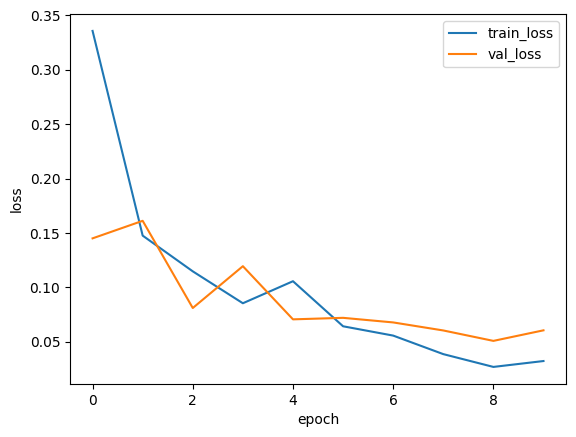

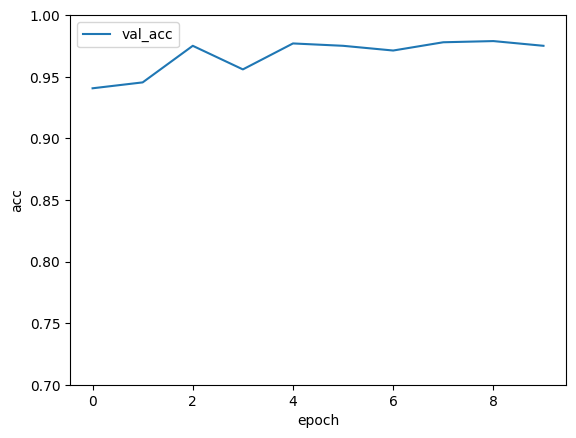

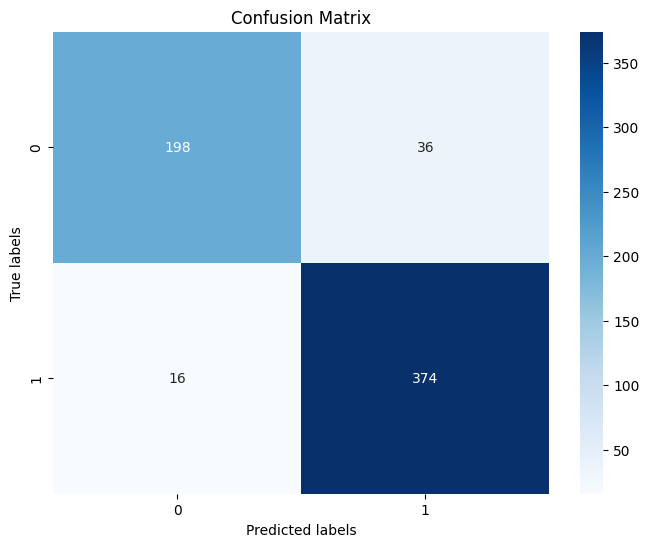

In [59]:
clear()
torch_seed()

loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=10

fc1_out=670
learning_rate=0.0009988758027416346
batch_size="64"

print(f"fc1 out : {fc1_out}  learning rate : {learning_rate}  batch size : {batch_size}")

cnn_best=Model_2(fc1_out).to(device=config.device)
optimizer=Adam(cnn_best.parameters(),lr=learning_rate)

torch_seed()
for epoch in range(epochs):
    loss=train(cnn_best,optimizer,train_dataloader[batch_size])
    val_loss,val_acc=valid(cnn_best,valid_dataloader[batch_size])
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

test_acc,cm,pred=test(cnn_best,test_dataloader)
print(f"test accuracy : {test_acc}")
f_score=f1_score(pred,test_df["labels"])
print(f"f1 score : {f_score}")

save_model(f"cnn_best_12_layers_{test_acc}",cnn_best)

plot_result(loss_list,val_loss_list,val_acc_list,cm)

# Resnet

## Find best hyper parameters by optuna

In [ ]:
# clear()
# def objective(trial):
    
#     torch_seed()

#     learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)
#     batch_size=trial.suggest_categorical("batch_size",["64","128","256"])

#     epochs=10
#     resnet_best=timm.create_model("resnet34",pretrained=True,num_classes=2).to(config.device)
#     optimizer=Adam(resnet_best.parameters(),lr=learning_rate)

#     torch_seed()
#     for epoch in range(epochs):
#         loss=train(resnet_best,optimizer,train_dataloader[batch_size])
#         val_loss,val_acc=valid(resnet_best,valid_dataloader[batch_size])
#         print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")

#     test_acc,_,__=test(resnet_best,test_dataloader)

#     return test_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# resnet_params = study.best_params
# print("Best Hyperparameters:", resnet_params)

# save_params("resnet_best",resnet_params)

## Best model of resnet34

### best hyper parameters
- learning_rate = 0.0005999252950268242
- batch_size = "256"

learning rate : 0.0005999252950268242  batch size : 256
train loss : 0.35043119507677417  val_loss : 0.1584508463740349  val_acc : 0.9540229885057471 
train loss : 0.07294922584996504  val_loss : 0.2787087053060532  val_acc : 0.8936781609195402 
train loss : 0.032195716411532724  val_loss : 0.0866169236600399  val_acc : 0.9597701149425287 
train loss : 0.017700334161739138  val_loss : 0.044148249365389344  val_acc : 0.9798850574712644 
train loss : 0.004788364872665089  val_loss : 0.028202681988477706  val_acc : 0.9904214559386973 
train loss : 0.0021715296932276994  val_loss : 0.027204755326965823  val_acc : 0.9894636015325671 
train loss : 0.001647610977456412  val_loss : 0.06887984573841095  val_acc : 0.985632183908046 
train loss : 0.0008527849448214778  val_loss : 0.02969635135959834  val_acc : 0.9894636015325671 
train loss : 0.0006204189626527403  val_loss : 0.034410298452712595  val_acc : 0.9894636015325671 
train loss : 0.00040218208382344423  val_loss : 0.03025019820779562  v

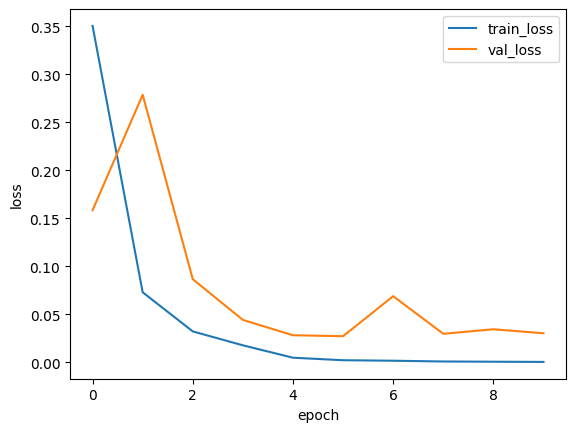

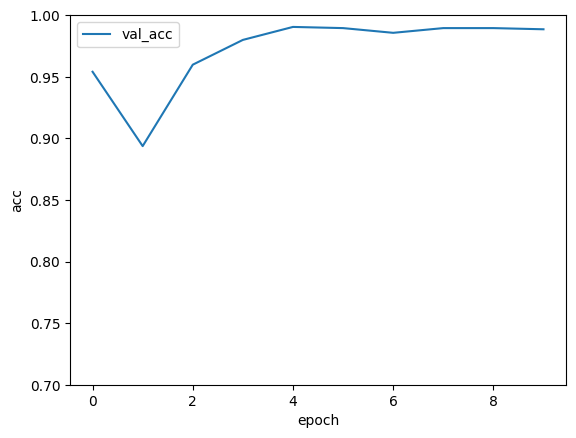

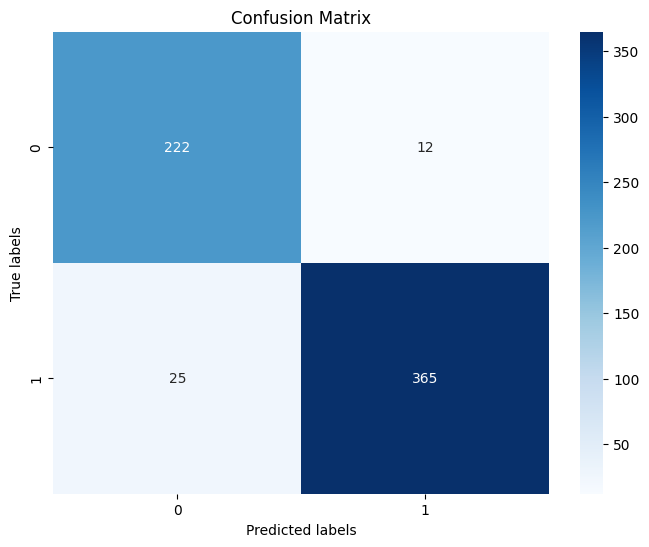

In [60]:
clear()
torch_seed()

loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=10

learning_rate=0.0005999252950268242
batch_size="256"

print(f"learning rate : {learning_rate}  batch size : {batch_size}")

resnet_best=timm.create_model("resnet34",pretrained=True,num_classes=2).to(config.device)
optimizer=Adam(resnet_best.parameters(),lr=learning_rate)

torch_seed()
for epoch in range(epochs):
    loss=train(resnet_best,optimizer,train_dataloader[batch_size])
    val_loss,val_acc=valid(resnet_best,valid_dataloader[batch_size])
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

test_acc,cm,pred=test(resnet_best,test_dataloader)
print(f"test accuracy : {test_acc}")
f_score=f1_score(pred,test_df["labels"])
print(f"f1 score : {f_score}")


save_model(f"resnet_best_{test_acc}",resnet_best)

plot_result(loss_list,val_loss_list,val_acc_list,cm)


# EfficientnetV2 b0

## Find best hyper parameters by optuna

In [ ]:
# def objective(trial):
#     clear()
#     torch_seed()

#     learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)
#     batch_size=trial.suggest_categorical("batch_size",["64","128","256"])
    
#     epochs=10
#     efficientnet=timm.create_model("tf_efficientnetv2_b0",pretrained=True).to(config.device)
#     optimizer=Adam(efficientnet.parameters(),lr=learning_rate)

#     torch_seed()
#     for epoch in range(epochs):
#         loss=train(efficientnet,optimizer,train_dataloader[batch_size])
#         val_loss,val_acc=valid(efficientnet,valid_dataloader[batch_size])
#         print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")

#     test_acc,_,__=test(efficientnet,test_dataloader)

#     return test_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# efficientnet_params = study.best_params
# print("Best Hyperparameters:", efficientnet_params)

# save_params("efficientnet_best",efficientnet_params)

## Best model of EfficientnetV2 b0

### best hyper parameters
- learning_rate = 0.0006050372788507134
- batch_size = "64"

learning rate : 0.0006050372788507134  batch size : 64
train loss : 0.46292440593242645  val_loss : 0.1134093833320281  val_acc : 0.9568965517241379 
train loss : 0.04228947808874319  val_loss : 0.056275864076965  val_acc : 0.9827586206896551 
train loss : 0.02009879986607385  val_loss : 0.045631793882314337  val_acc : 0.9827586206896551 
train loss : 0.012479671540363184  val_loss : 0.06937775964958265  val_acc : 0.9779693486590039 
train loss : 0.01965191637105873  val_loss : 0.04159770682728028  val_acc : 0.985632183908046 
train loss : 0.007927468996830143  val_loss : 0.028108616838889086  val_acc : 0.9923371647509579 
train loss : 0.001141865832930004  val_loss : 0.022139362589394508  val_acc : 0.9932950191570882 
train loss : 0.006029951705579261  val_loss : 0.09097584725275416  val_acc : 0.9827586206896551 
train loss : 0.009452591987086855  val_loss : 0.03698366465772886  val_acc : 0.9913793103448276 
train loss : 0.009674139672852383  val_loss : 0.11614880119176473  val_acc : 

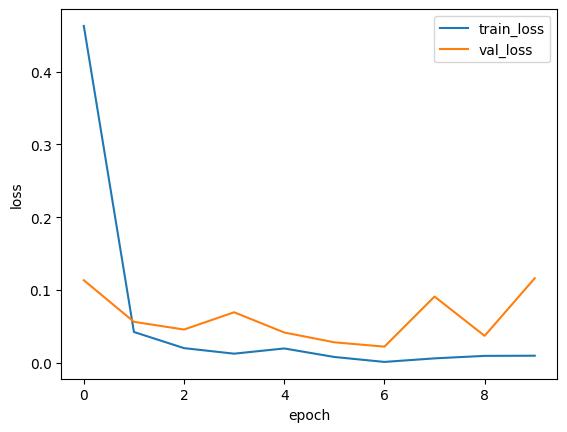

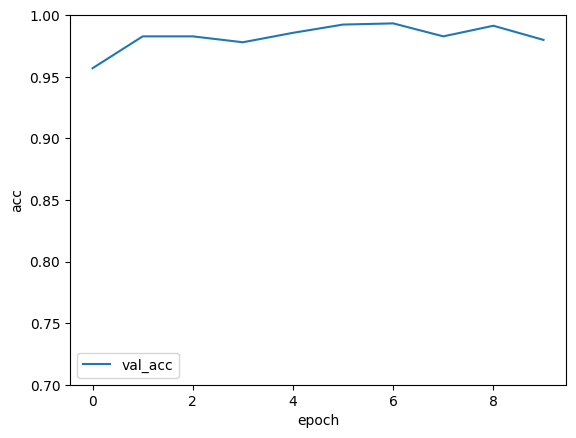

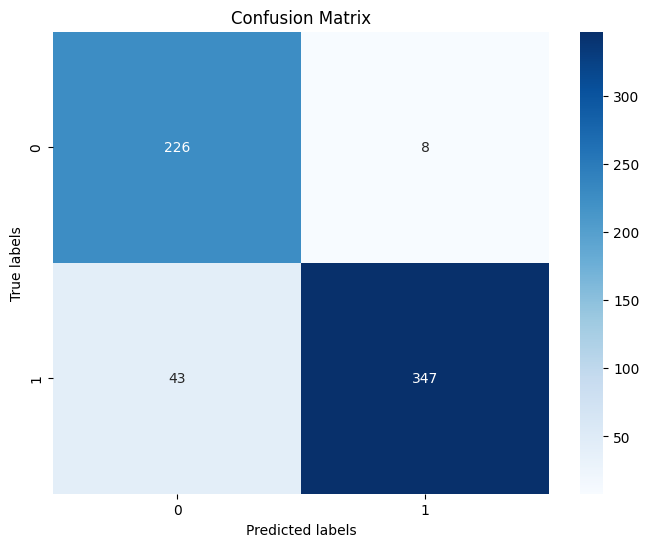

In [61]:
clear()
torch_seed()

loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=10
learning_rate=0.0006050372788507134
batch_size="64"

print(f"learning rate : {learning_rate}  batch size : {batch_size}")

efficientnet_best=timm.create_model("tf_efficientnetv2_b0",pretrained=True).to(config.device)
optimizer=Adam(efficientnet_best.parameters(),lr=learning_rate)

torch_seed()
for epoch in range(epochs):
    loss=train(efficientnet_best,optimizer,train_dataloader[batch_size])
    val_loss,val_acc=valid(efficientnet_best,valid_dataloader[batch_size])
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

test_acc,cm,pred=test(efficientnet_best,test_dataloader)
print(f"test accuracy : {test_acc}")
f_score=f1_score(pred,test_df["labels"])
print(f"f1 score : {f_score}")


save_model(f"efficientnet_best_{test_acc}",efficientnet_best)

plot_result(loss_list,val_loss_list,val_acc_list,cm)

# VGG16

## Find best hyper parameters by optuna

※ vgg16 pretrained model is so heavy 

In [22]:
# clear()
# def objective(trial):
    
#     torch_seed()

#     learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)

#     epochs=10
#     vgg=timm.create_model('vgg16.tv_in1k', pretrained=True,num_classes=2).to(config.device)
#     optimizer=Adam(vgg.parameters(),lr=learning_rate)

#     torch_seed()
#     for epoch in range(epochs):
#         loss=train(vgg,optimizer,train_dataloader)
#         val_loss,val_acc=valid(vgg,valid_dataloader)
#         print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")

#     test_acc,_,__=test(vgg,test_dataloader)

#     return test_acc

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# vgg_params = study.best_params
# print("Best Hyperparameters:", vgg_params)

# save_params("efficientnet_best",vgg_params)

### best hyper parameters
- learning_rate = 0.0005200581033804874
- batch_size = "256"

In [23]:
# clear()
# torch_seed()

# loss_list=[]
# val_loss_list=[]
# val_acc_list=[]

# epochs=10
# # learning_rate=vgg_params["learning_rate"]
# # batch_size=vgg_params["learning_rate"]

# learning_rate=0.0005200581033804874
# batch_size="256"

# vgg_best=timm.create_model('vgg16.tv_in1k',pretrained=True).to(config.device)
# optimizer=Adam(vgg_best.parameters(),lr=learning_rate)

# torch_seed()
# for epoch in range(epochs):
#     loss=train(vgg_best,optimizer,train_dataloader[batch_size])
#     val_loss,val_acc=valid(vgg_best,valid_dataloader[batch_size])
#     print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
#     loss_list.append(loss)
#     val_loss_list.append(val_loss)
#     val_acc_list.append(val_acc)

# test_acc,cm,pred=test(vgg_best,test_dataloader)
# print(f"test accuracy : {test_acc}")
# f_score=f1_score(pred,test_df["labels"])
# print(f"f1 score : {f_score}")

# save_model(f"vgg_best_{test_acc}",vgg_best)

# plot_result(loss_list,val_loss_list,val_acc_list,cm)

# Output prediction in CSV

In [71]:
_,__,pred=test(resnet_best,test_dataloader)

final_output=pd.concat([pd.DataFrame(test_df["filepaths"]),pd.DataFrame(pred)],axis=1)
final_output.rename(columns={0:"labels"},inplace=True)

class_mapping_rev = {config.class_mapping[k] : k for k in config.class_mapping}

final_output['labels'] = final_output['labels'].map(class_mapping_rev)

final_output.to_csv('submission.csv', index=False)